In [1]:
import os, re, pickle, warnings
import numpy as np
import pandas as pd
import xarray as xr
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Parámetros clave
LATENT_DIM = 8       # prueba 8/12/16 en ablations
BETA       = 1.0     # β-VAE (>=1 aumenta disentanglement)
LR         = 1e-3
EPOCHS     = 400
BATCH_SIZE = 64
PATIENCE   = 30
NOISE_STD  = 0.05

BASE_DECADES   = [2020]
TARGET_DECADES = [2040, 2060, 2080]

# Rutas (ajusta si corresponde)
BASE_DIR = "/home/aninotna/magister/tesis/justh2_pipeline"
DATA_DIR = os.path.join(BASE_DIR, "data/autoencoder_tensors")
MODE = "test"

PATH_SSP245       = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}.npz")
PATH_SSP370       = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}.npz")
PATH_SSP585       = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}.npz")
PATH_SSP245_ORIG  = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}_ORIGINAL.npz")
PATH_SSP370_ORIG  = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}_ORIGINAL.npz")
PATH_SSP585_ORIG  = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}_ORIGINAL.npz")
PATH_FEATURE_NAMES= os.path.join(DATA_DIR, f"feature_names_{MODE}.csv")
PATH_METADATA     = os.path.join(DATA_DIR, f"metadata_{MODE}.pkl")

print("✓ Config VAE lista")


✓ Config VAE lista


In [2]:
def load_npz_stack(path, is_original=False):
    data = np.load(path)
    if is_original:
        X = np.vstack([data["X_train_original"], data["X_val_original"], data["X_test_original"]])
    else:
        X = np.vstack([data["X_train"], data["X_val"], data["X_test"]])
    idx = np.concatenate([data["train_idx"], data["val_idx"], data["test_idx"]])
    return X, idx

X245n, idx245 = load_npz_stack(PATH_SSP245, is_original=False)
X370n, idx370 = load_npz_stack(PATH_SSP370, is_original=False)
X585n, idx585 = load_npz_stack(PATH_SSP585, is_original=False)

X245o, _ = load_npz_stack(PATH_SSP245_ORIG, is_original=True)
X370o, _ = load_npz_stack(PATH_SSP370_ORIG, is_original=True)
X585o, _ = load_npz_stack(PATH_SSP585_ORIG, is_original=True)

feature_names = pd.read_csv(PATH_FEATURE_NAMES)["feature_name"].tolist()

with open(PATH_METADATA, "rb") as f:
    meta = pickle.load(f)

mask       = meta["mask"]                       # (H,W) boolean
spat_info  = meta["spatial_info"]               # lat, lon, grid_shape
splits     = meta["splits"]                     # train/val/test idx

# Reconstruir coords en el orden del stack
lat = spat_info["lat"]; lon = spat_info["lon"]
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")
lat_flat = lat_grid[mask]; lon_flat = lon_grid[mask]
all_idx = np.concatenate([splits["train_idx"], splits["val_idx"], splits["test_idx"]])

coords_df = pd.DataFrame({
    "lat": lat_flat[all_idx],
    "lon": lon_flat[all_idx],
    "pixel_id": np.arange(len(all_idx))
})

print("Shapes norm:", X245n.shape, X370n.shape, X585n.shape)
print("Shapes orig:", X245o.shape, X370o.shape, X585o.shape)
print("Coords:", coords_df.shape)


Shapes norm: (661, 293) (661, 293) (661, 293)
Shapes orig: (661, 293) (661, 293) (661, 293)
Coords: (661, 3)


In [9]:
def cols_for_decades(names, decades):
    pat = re.compile(r"_decadal_(?:mean|max|min)_(\d{4})$")
    idx = []
    for j, n in enumerate(names):
        m = pat.search(n)
        if m and int(m.group(1)) in decades:
            idx.append(j)
    return idx

def non_decadal_cols(names):
    return [j for j, n in enumerate(names) if "_decadal_" not in n]

base_idx = cols_for_decades(feature_names, BASE_DECADES)
tgt_idx  = cols_for_decades(feature_names, TARGET_DECADES)
non_idx  = non_decadal_cols(feature_names)

print(f"Índices encontrados:")
print(f"  base_idx (2020): {len(base_idx)} features")
print(f"  tgt_idx (2040/60/80): {len(tgt_idx)} features")
print(f"  non_idx (estáticas): {len(non_idx)} features")

def build_block(Xn):
    """
    Construye matrices BASE y TGT con la MISMA dimensionalidad.
    
    BASE: década 2020 + estáticas
    TGT:  PROMEDIO de décadas target (2040/60/80) + estáticas
    
    Esto asegura que ambas matrices tengan el mismo número de features.
    """
    # BASE: década 2020 + estáticas
    BASE = np.hstack([Xn[:, base_idx], Xn[:, non_idx]])
    
    # TGT: Promedio de las 3 décadas target + estáticas
    # Las features decenales están organizadas secuencialmente por década
    X_tgt = Xn[:, tgt_idx]
    n_samples = X_tgt.shape[0]
    n_decades = len(TARGET_DECADES)
    n_vars_per_decade = len(tgt_idx) // n_decades
    
    # Reshape: (samples, decades, vars_per_decade)
    X_tgt_reshaped = X_tgt.reshape(n_samples, n_decades, n_vars_per_decade)
    
    # Promedio sobre las décadas
    X_tgt_mean = X_tgt_reshaped.mean(axis=1)  # (samples, vars_per_decade)
    
    # Combinar con estáticas
    TGT = np.hstack([X_tgt_mean, Xn[:, non_idx]])
    
    return BASE, TGT

B245, T245 = build_block(X245n)
B370, T370 = build_block(X370n)
B585, T585 = build_block(X585n)

# Verificar dimensionalidad
print(f"\n✓ Dimensionalidad verificada:")
print(f"  B245: {B245.shape}, T245: {T245.shape}")
print(f"  B370: {B370.shape}, T370: {T370.shape}")
print(f"  B585: {B585.shape}, T585: {T585.shape}")

assert B245.shape[1] == T245.shape[1], "❌ B245 y T245 tienen diferente número de features"
assert B370.shape[1] == T370.shape[1], "❌ B370 y T370 tienen diferente número de features"
assert B585.shape[1] == T585.shape[1], "❌ B585 y T585 tienen diferente número de features"

# baseline combinado para entrenar VAE robusto
X_BASE = np.vstack([B245, B370, B585])

print(f"\nX_BASE (combinado): {X_BASE.shape}")
print(f"✓ Todas las matrices tienen {B245.shape[1]} features")


Índices encontrados:
  base_idx (2020): 24 features
  tgt_idx (2040/60/80): 72 features
  non_idx (estáticas): 13 features

✓ Dimensionalidad verificada:
  B245: (661, 37), T245: (661, 37)
  B370: (661, 37), T370: (661, 37)
  B585: (661, 37), T585: (661, 37)

X_BASE (combinado): (1983, 37)
✓ Todas las matrices tienen 37 features


In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=12, p_drop=0.05):  # latent_dim ↑
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.mu     = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, input_dim),
        )
    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar

def elbo_loss(x, x_hat, mu, logvar, beta=1.0):
    recon = F.mse_loss(x_hat, x, reduction="mean")
    # KL(N(mu, sigma)||N(0,I)) = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta*kl, recon, kl

# split
perm = np.random.permutation(X_BASE.shape[0])
n_val = int(0.2 * len(perm))
val_idx, tr_idx = perm[:n_val], perm[n_val:]
X_tr, X_val = X_BASE[tr_idx], X_BASE[val_idx]

def beta_schedule(ep, warmup=60, max_beta=1.0):
    # lineal: 0.1 → 1.0
    if ep < 5: return 0.1
    if ep < warmup: return 0.1 + (max_beta-0.1)*(ep-5)/(warmup-5)
    return max_beta

def train_vae(model, X_tr, X_val, epochs=400, lr=1e-3, batch_size=64,
              beta=1.0, weight_decay=1e-4, noise_std=0.05, patience=30, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    Xtr = torch.tensor(X_tr, dtype=torch.float32)
    Xva = torch.tensor(X_val, dtype=torch.float32)
    best, best_val, wait = None, float("inf"), 0
    for ep in range(epochs):
        model.train()
        cur_beta = beta_schedule(ep, warmup=80, max_beta=BETA) 
        idx = torch.randperm(Xtr.size(0))
        for i in range(0, Xtr.size(0), batch_size):
            batch = Xtr[idx[i:i+batch_size]]
            noisy = batch + noise_std*torch.randn_like(batch)
            opt.zero_grad()
            x_hat, mu, logvar = model(noisy)
            loss, recon, kl = elbo_loss(batch, x_hat, mu, logvar, beta=cur_beta)  # <= usa cur_beta
            loss.backward()
            opt.step()
        model.eval()
        with torch.no_grad():
            xh, mu_v, lv_v = model(Xva)
            val, r_v, kl_v = elbo_loss(Xva, xh, mu_v, lv_v, beta=cur_beta)
            val = val.item()
        if verbose and ep % 25 == 0:
            print(f"ep {ep:03d} | val={val:.6f} (recon={r_v:.6f}, kl={kl_v:.6f})")
        if val < best_val - 1e-6:
            best_val = val; wait = 0
            best = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                if verbose: print(f"Early stop @ {ep} | best={best_val:.6f}")
                break
    if best is not None:
        model.load_state_dict(best)
    return model

input_dim = X_BASE.shape[1]
vae = VAE(input_dim, latent_dim=LATENT_DIM, p_drop=0.1)
vae = train_vae(vae, X_tr, X_val, epochs=EPOCHS, lr=LR, beta=BETA,
                batch_size=BATCH_SIZE, weight_decay=1e-4,
                noise_std=NOISE_STD, patience=PATIENCE)
print("✓ VAE entrenado")


ep 000 | val=1.111798 (recon=1.064513, kl=0.472850)
ep 025 | val=0.395966 (recon=0.212043, kl=0.540951)
ep 025 | val=0.395966 (recon=0.212043, kl=0.540951)
Early stop @ 45 | best=0.354412
✓ VAE entrenado
Early stop @ 45 | best=0.354412
✓ VAE entrenado


In [32]:
@torch.no_grad()
def get_mu_logvar(model, X):
    X_t = torch.tensor(X, dtype=torch.float32)
    _, mu, logvar = model(X_t)
    return mu.numpy(), logvar.numpy()

mu_B  , lv_B   = get_mu_logvar(vae, X_BASE)
mu_B245, lv_B245 = get_mu_logvar(vae, B245)
mu_B370, lv_B370 = get_mu_logvar(vae, B370)
mu_B585, lv_B585 = get_mu_logvar(vae, B585)

mu_245, lv_245 = get_mu_logvar(vae, T245)
mu_370, lv_370 = get_mu_logvar(vae, T370)
mu_585, lv_585 = get_mu_logvar(vae, T585)

# Clustering en baseline (μ de base)
ks = (4,5,6,7,8,10)
best_k, best_s = None, -1
for k in ks:
    km_tmp = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(mu_B)
    sc = silhouette_score(mu_B, km_tmp.labels_)
    if sc > best_s:
        best_k, best_s = k, sc
km = KMeans(n_clusters=best_k or 6, n_init=10, random_state=SEED).fit(mu_B)

clB_245 = km.predict(mu_B245)
clB_370 = km.predict(mu_B370)
clB_585 = km.predict(mu_B585)

cl_245 = km.predict(mu_245)
cl_370 = km.predict(mu_370)
cl_585 = km.predict(mu_585)

print(f"K≈{km.n_clusters} (silhouette≈{best_s:.3f})")


K≈10 (silhouette≈0.414)


In [33]:
def mahalanobis(mu_f, mu_b, lv_b):
    # Σ_b = diag(exp(lv_b))
    inv_var = 1.0 / np.exp(lv_b)
    diff = mu_f - mu_b
    return np.sqrt((diff**2 * inv_var).sum(axis=1))

def kl_diag(mu_p, lv_p, mu_q, lv_q):
    var_p = np.exp(lv_p); var_q = np.exp(lv_q); dim = mu_p.shape[1]
    term1 = (np.log(var_q) - np.log(var_p)).sum(axis=1)
    term2 = ((var_p + (mu_p - mu_q)**2) / var_q).sum(axis=1)
    return 0.5 * (term1 + term2 - dim)

def kl_sym(mu_a, lv_a, mu_b, lv_b):
    return 0.5*(kl_diag(mu_a, lv_a, mu_b, lv_b) + kl_diag(mu_b, lv_b, mu_a, lv_a))

mah_245 = mahalanobis(mu_245, mu_B245, lv_B245)
mah_370 = mahalanobis(mu_370, mu_B370, lv_B370)
mah_585 = mahalanobis(mu_585, mu_B585, lv_B585)

kls_245 = kl_sym(mu_245, lv_245, mu_B245, lv_B245)
kls_370 = kl_sym(mu_370, lv_370, mu_B370, lv_B370)
kls_585 = kl_sym(mu_585, lv_585, mu_B585, lv_B585)


In [34]:
def mu_shift(mu_fut, mu_base):
    return np.linalg.norm(mu_fut - mu_base, axis=1)

def var_expansion(lv_fut, lv_base):
    # tr(Σ_fut) - tr(Σ_base) con Σ = diag(exp(logvar))
    tr_fut  = np.exp(lv_fut).sum(axis=1)
    tr_base = np.exp(lv_base).sum(axis=1)
    return tr_fut - tr_base

def kl_gaussians(mu_p, lv_p, mu_q, lv_q):
    # KL( N(mu_p, Σ_p) || N(mu_q, Σ_q) ) para diagonales
    # 0.5 * [ sum( log(σ_q^2/σ_p^2) + (σ_p^2 + (mu_p - mu_q)^2)/σ_q^2 - 1 ) ]
    var_p = np.exp(lv_p); var_q = np.exp(lv_q)
    term1 = (np.log(var_q) - np.log(var_p)).sum(axis=1)
    term2 = ((var_p + (mu_p - mu_q)**2) / var_q).sum(axis=1)
    dim   = mu_p.shape[1]
    return 0.5 * (term1 + term2 - dim)

# Por escenario (pares baseline vs futuro DEL MISMO SSP)
mshift_245 = mu_shift(mu_245, mu_B245)
mshift_370 = mu_shift(mu_370, mu_B370)
mshift_585 = mu_shift(mu_585, mu_B585)

vexp_245 = var_expansion(lv_245, lv_B245)
vexp_370 = var_expansion(lv_370, lv_B370)
vexp_585 = var_expansion(lv_585, lv_B585)

kl_245 = kl_gaussians(mu_245, lv_245, mu_B245, lv_B245)
kl_370 = kl_gaussians(mu_370, lv_370, mu_B370, lv_B370)
kl_585 = kl_gaussians(mu_585, lv_585, mu_B585, lv_B585)

# Estabilidad de clúster
stab_245 = (cl_245 == clB_245).astype(int)
stab_370 = (cl_370 == clB_370).astype(int)
stab_585 = (cl_585 == clB_585).astype(int)

print("Medianas | mu-shift:", np.median(mshift_245), np.median(mshift_370), np.median(mshift_585))
print("Medianas | var-exp :", np.median(vexp_245),  np.median(vexp_370),  np.median(vexp_585))
print("Medianas | KL      :", np.median(kl_245),    np.median(kl_370),    np.median(kl_585))
print("Mean stab:", stab_245.mean(), stab_370.mean(), stab_585.mean())


Medianas | mu-shift: 0.9893792 3.3145013 3.4510548
Medianas | var-exp : 0.13975763 0.023930073 -0.6528053
Medianas | KL      : 4.205434 86.17671 72.72294
Mean stab: 0.8154311649016641 0.0 0.0


              R_245         R_370         R_585
count  6.610000e+02  6.610000e+02  6.610000e+02
mean  -6.506834e-09 -5.658998e-08  1.689215e-08
std    4.664670e-01  2.708640e-01  2.937129e-01
min   -2.766125e+00 -6.750083e-01 -7.039011e-01
25%   -2.391544e-01 -2.155049e-01 -2.214223e-01
50%    1.037914e-01  2.742260e-02 -4.102524e-02
75%    3.391901e-01  1.939335e-01  2.201030e-01
max    6.759969e-01  6.109576e-01  6.770604e-01


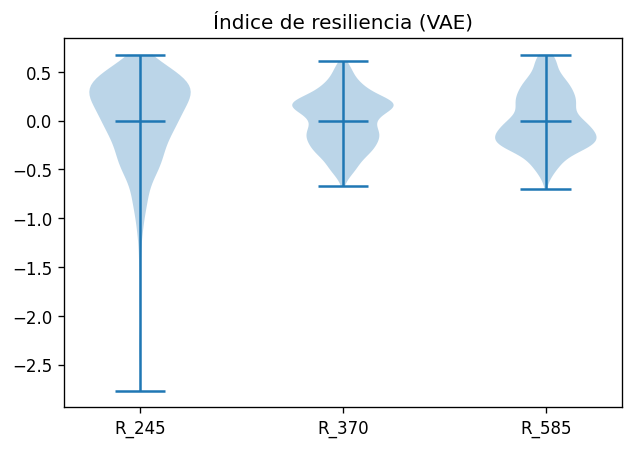

In [22]:
# Helpers H2
def get_h2_cols(names, decades):
    pat = re.compile(r"calliope_h2_prod_ton_decadal_(?:mean|max|min)_(\d{4})$")
    idx = [j for j, n in enumerate(names) if (m:=pat.search(n)) and int(m.group(1)) in decades]
    if idx: return idx
    if "calliope_h2_prod_ton" in names: return [names.index("calliope_h2_prod_ton")]
    raise ValueError("No encuentro columnas de H2 (decenales ni estática).")

h2b_idx = get_h2_cols(feature_names, BASE_DECADES)
h2t_idx = get_h2_cols(feature_names, TARGET_DECADES)

def take_h2(Xo, idxs):
    H = Xo[:, idxs]
    return H.mean(axis=1) if H.ndim==2 and H.shape[1]>1 else H.squeeze()

H2B_245 = take_h2(X245o, h2b_idx); H2_245 = take_h2(X245o, h2t_idx)
H2B_370 = take_h2(X370o, h2b_idx); H2_370 = take_h2(X370o, h2t_idx)
H2B_585 = take_h2(X585o, h2b_idx); H2_585 = take_h2(X585o, h2t_idx)

eps=1e-8 + (H2B_245==0)*1e-3
drop_245 = (H2B_245 - H2_245)/(H2B_245+eps)
drop_370 = (H2B_370 - H2_370)/(H2B_370+eps)
drop_585 = (H2B_585 - H2_585)/(H2B_585+eps)

def z(x): x=np.asarray(x); return (x - np.nanmean(x)) / (np.nanstd(x)+1e-9)

# Índice VAE (ponderado): penaliza shift, var-expansion y KL; premia estabilidad
def R_vae(mshift, vexp, kl, stab, drop, w_ms=1.0, w_v=0.5, w_kl=1.0, w_st=1.0, w_h2=2.0):
    num = -w_ms*z(mshift) - w_v*z(vexp) - w_kl*z(kl) + w_st*z(stab) - w_h2*z(drop)
    den = (w_ms + w_v + w_kl + w_st + w_h2)
    return num / den

R245 = R_vae(mshift_245, vexp_245, kl_245, stab_245, drop_245)
R370 = R_vae(mshift_370, vexp_370, kl_370, stab_370, drop_370)
R585 = R_vae(mshift_585, vexp_585, kl_585, stab_585, drop_585)

print(pd.DataFrame({"R_245":R245,"R_370":R370,"R_585":R585}).describe())

plt.figure(figsize=(6,4))
plt.violinplot([R245,R370,R585], showmeans=True)
plt.xticks([1,2,3], ["R_245","R_370","R_585"])
plt.title("Índice de resiliencia (VAE)")
plt.show()


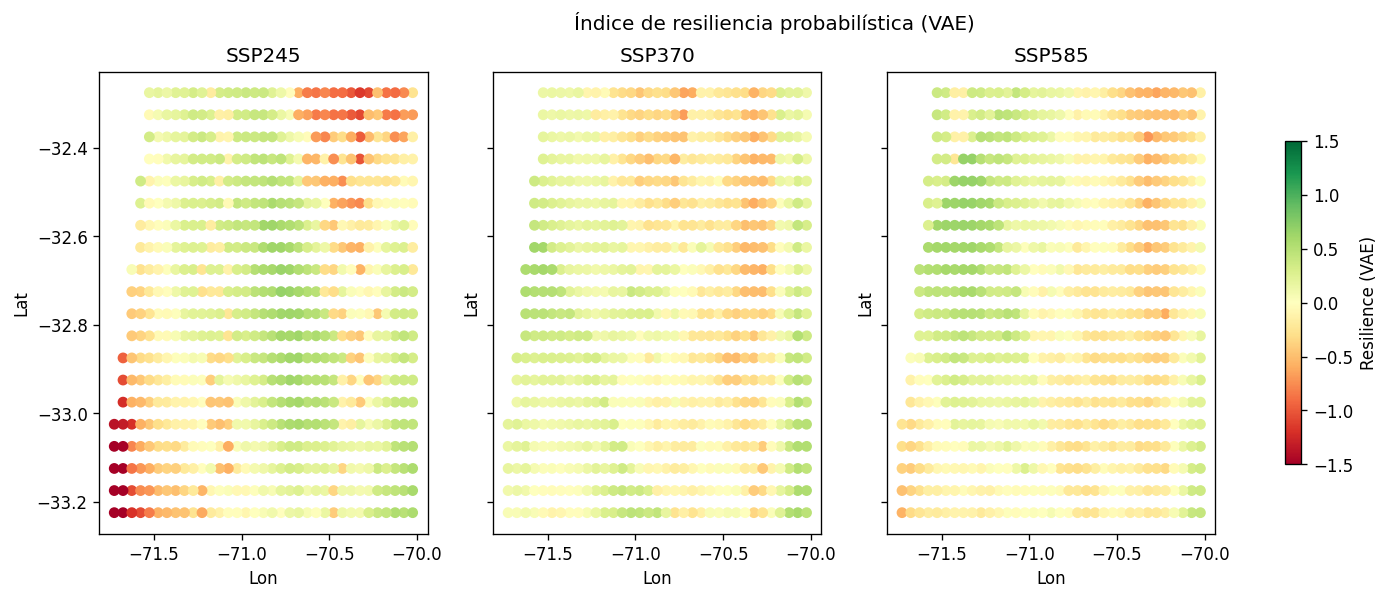

In [23]:
res_df = pd.DataFrame({
    "pixel_id": coords_df["pixel_id"],
    "lat": coords_df["lat"], "lon": coords_df["lon"],
    "R_245": R245, "R_370": R370, "R_585": R585
})

fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
for ax, col, ttl in zip(axes, ["R_245","R_370","R_585"], ["SSP245","SSP370","SSP585"]):
    sc=ax.scatter(res_df["lon"], res_df["lat"], c=res_df[col], s=30, cmap="RdYlGn", vmin=-1.5, vmax=1.5)
    ax.set_title(ttl); ax.set_xlabel("Lon"); ax.set_ylabel("Lat")
fig.colorbar(sc, ax=axes, shrink=0.7, label="Resilience (VAE)")
plt.suptitle("Índice de resiliencia probabilística (VAE)")
plt.show()


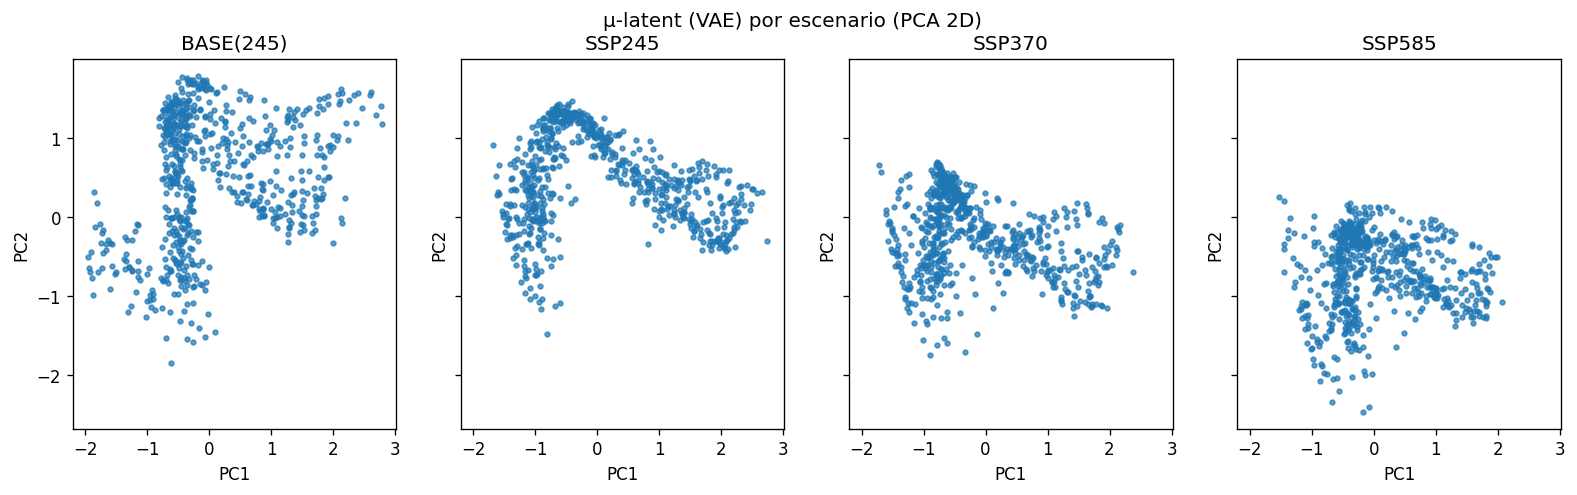

In [24]:
Z_all = np.vstack([mu_B245, mu_245, mu_370, mu_585])
pca = PCA(n_components=2, random_state=SEED).fit(Z_all)
MB245_2 = pca.transform(mu_B245)
M245_2  = pca.transform(mu_245)
M370_2  = pca.transform(mu_370)
M585_2  = pca.transform(mu_585)

fig, axes = plt.subplots(1,4, figsize=(16,4), sharex=True, sharey=True)
for ax, M2, ttl in zip(axes, [MB245_2,M245_2,M370_2,M585_2], ["BASE(245)","SSP245","SSP370","SSP585"]):
    ax.scatter(M2[:,0], M2[:,1], s=8, alpha=0.7)
    ax.set_title(ttl); ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.suptitle("μ-latent (VAE) por escenario (PCA 2D)")
plt.show()


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def probe(X, y, nsplit=5):
    kf = KFold(n_splits=nsplit, shuffle=True, random_state=42)
    r2s=[]
    for tr, te in kf.split(X):
        m=LinearRegression().fit(X[tr], y[tr])
        r2s.append(r2_score(y[te], m.predict(X[te])))
    return np.mean(r2s), np.std(r2s)

# ejemplo con μ de SSP585 contra ΔCF_585
X_probe = mu_585
y_probe = drop_585
print("Probe μ→ΔCF (585): R2 =", probe(X_probe, y_probe)[0])


Probe μ→ΔCF (585): R2 = 1.0


In [25]:
# Exportar modelo VAE y embeddings para notebook 06
import torch

OUTPUT_DIR = os.path.join(BASE_DIR, "data/autoencoder_trained_v2")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Guardar modelo VAE (state_dict)
model_path = os.path.join(OUTPUT_DIR, f"vae_model_latent{LATENT_DIM}_beta{BETA}_{MODE}.pth")
torch.save(vae.state_dict(), model_path)
print(f"✓ Modelo VAE guardado en: {model_path}")

# 2. Guardar embeddings (μ y logvar) en formato .npz
latents_path = os.path.join(OUTPUT_DIR, f"vae_latents_{MODE}.npz")
np.savez_compressed(
    latents_path,
    # Baseline por SSP (μ y logvar)
    mu_B245=mu_B245, lv_B245=lv_B245,
    mu_B370=mu_B370, lv_B370=lv_B370,
    mu_B585=mu_B585, lv_B585=lv_B585,
    # Target por SSP (μ y logvar)
    mu_245=mu_245, lv_245=lv_245,
    mu_370=mu_370, lv_370=lv_370,
    mu_585=mu_585, lv_585=lv_585,
    # Baseline combinado
    mu_B=mu_B, lv_B=lv_B,
    # Clusters baseline
    clB_245=clB_245, clB_370=clB_370, clB_585=clB_585,
    # Clusters target
    cl_245=cl_245, cl_370=cl_370, cl_585=cl_585,
    # Metadata del clustering
    n_clusters=km.n_clusters,
    cluster_centers=km.cluster_centers_
)
print(f"✓ Embeddings VAE guardados en: {latents_path}")

# 3. Guardar métricas de resiliencia calculadas
metrics_path = os.path.join(OUTPUT_DIR, f"vae_metrics_{MODE}.npz")
np.savez_compressed(
    metrics_path,
    # Métricas latentes
    mshift_245=mshift_245, mshift_370=mshift_370, mshift_585=mshift_585,
    vexp_245=vexp_245, vexp_370=vexp_370, vexp_585=vexp_585,
    kl_245=kl_245, kl_370=kl_370, kl_585=kl_585,
    # Estabilidad de clusters
    stab_245=stab_245, stab_370=stab_370, stab_585=stab_585,
    # Índices de resiliencia
    R_245=R245, R_370=R370, R_585=R585
)
print(f"✓ Métricas VAE guardadas en: {metrics_path}")

print(f"\nArchivos exportados para consumo en notebook 06:")
print(f"  - Modelo: {os.path.basename(model_path)}")
print(f"  - Embeddings: {os.path.basename(latents_path)}")
print(f"  - Métricas: {os.path.basename(metrics_path)}")

✓ Modelo VAE guardado en: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_trained_v2/vae_model_latent8_beta1.0_test.pth
✓ Embeddings VAE guardados en: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_trained_v2/vae_latents_test.npz
✓ Métricas VAE guardadas en: /home/aninotna/magister/tesis/justh2_pipeline/data/autoencoder_trained_v2/vae_metrics_test.npz

Archivos exportados para consumo en notebook 06:
  - Modelo: vae_model_latent8_beta1.0_test.pth
  - Embeddings: vae_latents_test.npz
  - Métricas: vae_metrics_test.npz
